# Practice notebook

In [2]:
from braket.ahs.hamiltonian import Hamiltonian
from braket.ahs.atom_arrangement import AtomArrangement
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation
from braket.timings.time_series import TimeSeries
from braket.ahs.driving_field import DrivingField
from braket.ahs.field import Field
from braket.ahs.pattern import Pattern
from braket.ahs.shifting_field import ShiftingField

from braket.devices import LocalSimulator


from ahs_utils import show_drive_and_shift
from ahs_utils import show_register

import numpy as np

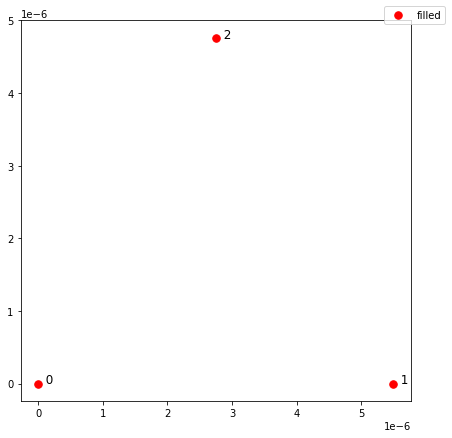

In [47]:
# Define H and register (2D atom arrangement)
register = AtomArrangement()
H = Hamiltonian()

ahs_program = AnalogHamiltonianSimulation(
    hamiltonian=H,
    register=register
)

# Build the register

# e.g. three atoms in an equilateral triangle, with pairwise
# separation equal to 5.5 micrometers
a = 5.5e-6  # meters

register.add([0, 0])
register.add([a, 0.0])
register.add([0.5 * a, np.sqrt(3)/2 * a]);

show_register(register)

In [49]:
# H drive
# e.g. trapzoid amplitude time series
Omega_max = 2.5e6  # rad / seconds

# e.g. the duration of the program
t_max = np.pi/(np.sqrt(2)*Omega_max) # seconds

# e.g. constant Rabi frequency
Omega = TimeSeries()
Omega.put(0.0, Omega_max)
Omega.put(t_max, Omega_max)
print(Omega.times())
print(Omega.values())

# e.g. all-zero phase and detuning
phi = TimeSeries().put(0.0, 0.0).put(t_max, 0.0)  # (time [s], value [rad])
Delta_global = TimeSeries().put(0.0, 0.0).put(t_max, 0.0)  # (time [s], value [rad/s])

drive = DrivingField(
    amplitude=Omega,
    phase=phi,
    detuning=Delta_global
)

H += drive
H

[0.0, 8.885765876316732e-07]
[2500000.0, 2500000.0]


In [53]:
# H shift
# e.g. constant strong shifting field
Delta_local = TimeSeries()
Delta_local.put(0.0, -Omega_max*20)  # (time [s], value [rad/s])
Delta_local.put(t_max, -Omega_max*20)
print(Delta_local.times())
print(Delta_local.values())

# e.g. the shifting field only acts on the third atom, 
# which is the top atom in the triangular array.
h = Pattern([0, 0, 0.5])

shift = ShiftingField(
    magnitude=Field(
        time_series=Delta_local,
        pattern=h
    )
)

H += shift

[0.0, 8.885765876316732e-07]
[-50000000.0, -50000000.0]


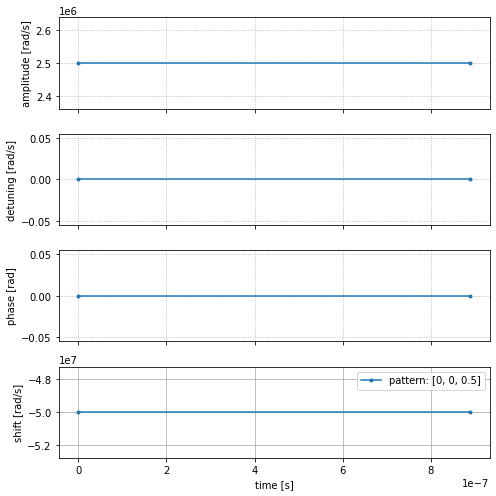

In [45]:
show_drive_and_shift(drive, shift)


In [52]:
ahs_program.to_ir().dict()

{'braketSchemaHeader': {'name': 'braket.ir.ahs.program', 'version': '1'},
 'setup': {'ahs_register': {'sites': [[Decimal('0'), Decimal('0')],
    [Decimal('0.0000055'), Decimal('0.0')],
    [Decimal('0.00000275'), Decimal('0.000004763139720814412')]],
   'filling': [1, 1, 1]}},
 'hamiltonian': {'drivingFields': [{'amplitude': {'time_series': {'values': [Decimal('2500000.0'),
       Decimal('2500000.0')],
      'times': [Decimal('0.0'), Decimal('8.885765876316732E-7')]},
     'pattern': 'uniform'},
    'phase': {'time_series': {'values': [Decimal('0.0'), Decimal('0.0')],
      'times': [Decimal('0.0'), Decimal('8.885765876316732E-7')]},
     'pattern': 'uniform'},
    'detuning': {'time_series': {'values': [Decimal('0.0'), Decimal('0.0')],
      'times': [Decimal('0.0'), Decimal('8.885765876316732E-7')]},
     'pattern': 'uniform'}}],
  'shiftingFields': [{'magnitude': {'time_series': {'values': [Decimal('-50000000.0'),
       Decimal('-50000000.0')],
      'times': [Decimal('0.0'), Dec

## Run the program

In [59]:
device = LocalSimulator()

ValueError: Only the following devices are available dict_keys([])

# Maximum Independent Sets with Analog Hamiltonian Simulation

In [4]:
import networkx as nx

from braket.ahs.hamiltonian import Hamiltonian
from braket.ahs.atom_arrangement import AtomArrangement
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation

from braket.timings.time_series import TimeSeries
from braket.ahs.driving_field import DrivingField
from braket.ahs.shifting_field import ShiftingField
from braket.ahs.field import Field
from braket.devices import LocalSimulator

import matplotlib.pyplot as plt
import time
import numpy as np

from scipy import optimize

# constants
atoms_w = 3
atoms_l = 4
blockade_radius = 7.5
np.random.seed(92)

In [5]:
def generate_unit_disk(atoms_l: int, atoms_w: int, scale=4.0*1e-6, dropout=0.45):
    atom_list = []
    edge_dict = {}
    atom_to_edge = {}
    for ii in range(atoms_l):
        for jj in range(atoms_w):
            atom_list.append((ii*scale, jj*scale))
            atom_to_edge[(ii*scale, jj*scale)] = ii*atoms_w + jj
            edge_dict[ii*atoms_w + jj] = []
            if jj < atoms_w - 1:
                edge_dict[ii*atoms_w + jj].append(ii*atoms_w + jj + 1)
            if ii < atoms_l - 1:
                edge_dict[ii*atoms_w + jj].append((ii+1)*atoms_w + jj)
            if ii < atoms_l - 1 and jj < atoms_w - 1:
                # nearest neighbor
                edge_dict[ii*atoms_w + jj].append((ii+1)*atoms_w + jj + 1)
            if jj > 0 and ii < atoms_l - 1:
                # nearest neighbor
                edge_dict[ii*atoms_w + jj].append((ii+1)*atoms_w + jj - 1)

    graph = nx.from_dict_of_lists(edge_dict)
    
    # perform dropout
    new_len = int(np.round(len(atom_list) * (1 - dropout)))
    atom_arr = np.empty(len(atom_list), dtype=object)
    atom_arr[:] = atom_list
    remaining_atom_list = np.random.choice(atom_arr, new_len, replace=False)
    
    dropped_edge_dict = {}
    atoms = AtomArrangement()
    for atom in remaining_atom_list:
        atoms.add(atom)
    graph.remove_nodes_from([atom_to_edge[atom] for atom in  set(atom_list) - set(list(remaining_atom_list))])

    return atoms, graph

In [6]:
atoms, graph = generate_unit_disk(atoms_l, atoms_w)

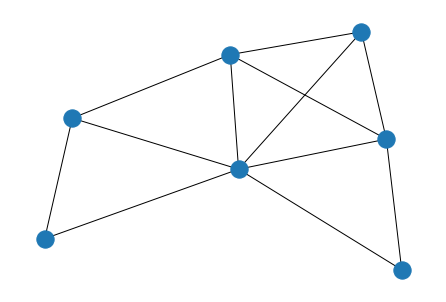

In [22]:
nx.draw(graph)